## Zillow Sales versus List prices weekly for major US cities

In [19]:
# Loading in the basics
import psycopg2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from config import password

In [20]:
# Connect to postgres db
ENDPOINT="ucb-data-group-project-zillow.csaw135fqqkl.us-west-1.rds.amazonaws.com"
PORT="5432"
USR="postgres"
REGION="us-west-1"


In [21]:
DBNAME="postgres"

conn = psycopg2.connect(database = DBNAME,
                        user =     USR,
                        password = password,
                        host =     ENDPOINT,
                        port =     PORT)

In [22]:
# list table sql
list_sql = '''
            SELECT *
            FROM list;
            '''

In [23]:

# census table sql
census_sql = '''
            SELECT *
            FROM census;
            '''

In [24]:
# sale table sql
sale_sql = '''
            SELECT *
            FROM sale;
            '''

In [25]:
# setting up dfs
list_df = pd.read_sql(list_sql, conn)
sale_df = pd.read_sql(sale_sql, conn)
censca_state_df = pd.read_sql(census_sql, conn)


In [26]:
# general cleaning
list_df = list_df.drop(["region_date","region_id", "region_type"],1)

sale_df = sale_df.drop(["region_date","region_id", "region_type"],1)

list_df.head()

,size_rank,region_name,state_name,date,price
0,0,United States,None,2017-11-04,275448.0
1,1,"New York, NY",NY,2017-11-04,526850.0
2,2,"Los Angeles-Long Beach-Anaheim, CA",CA,2017-11-04,812252.0
3,3,"Chicago, IL",IL,2017-11-04,319556.0
4,4,"Dallas-Fort Worth, TX",TX,2017-11-04,347537.0


In [27]:
# cleaning list and sale data

state_list = list_df.loc[list_df["region_name"] != "United States"]
state_list = state_list.drop(["region_name"], 1)
state_list = state_list.set_index("date").sort_index()
state_list = state_list.rename(columns = {"price":"list price"})

state_sale = sale_df.loc[sale_df["region_name"] != "United States"]
state_sale = state_sale.drop(["region_name"], 1)
state_sale = state_sale.set_index("date").sort_index()
state_sale = state_sale.rename(columns = {"price":"sale price"})

state_list.head()


,size_rank,state_name,list price
date,,,
2017-11-04,1,NY,526850.0
2017-11-04,70,OH,157843.0
2017-11-04,69,LA,237501.0
2017-11-04,68,TX,171751.0
2017-11-04,67,PA,250848.0


In [28]:
# creating a dictionary to make life potentially easier

state_list_dict = {k: v for k, v in state_list.groupby("state_name")}

state_sale_dict = {k: v for k, v in state_sale.groupby("state_name")}

In [29]:
import pprint

pprint.pprint(state_list_dict["CA"])

            size_rank state_name  list price
date                                        
2017-11-04         66         CA    779777.0
2017-11-04         63         CA    265423.0
2017-11-04         56         CA    338397.0
2017-11-04         77         CA    408007.0
2017-11-04         17         CA    728005.0
...               ...        ...         ...
2021-06-26         13         CA    539520.0
2021-06-26         11         CA    995750.0
2021-06-26          2         CA    998350.0
2021-06-26         34         CA   1306875.0
2021-06-26         25         CA    622250.0

[1910 rows x 3 columns]


In [30]:
# state dataframes for mapping

ca_list = state_list_dict["CA"].groupby(state_list_dict["CA"].index).mean()
tx_list = state_list_dict["TX"].groupby(state_list_dict["TX"].index).mean()
fl_list = state_list_dict["FL"].groupby(state_list_dict["FL"].index).mean()
ny_list = state_list_dict["NY"].groupby(state_list_dict["NY"].index).mean()
pa_list = state_list_dict["PA"].groupby(state_list_dict["PA"].index).mean()
il_list = state_list_dict["IL"].groupby(state_list_dict["IL"].index).mean()
oh_list = state_list_dict["OH"].groupby(state_list_dict["OH"].index).mean()
ga_list = state_list_dict["GA"].groupby(state_list_dict["GA"].index).mean()
nc_list = state_list_dict["NC"].groupby(state_list_dict["NC"].index).mean()
mi_list = state_list_dict["MI"].groupby(state_list_dict["MI"].index).mean()

ca_sale = state_sale_dict["CA"].groupby(state_sale_dict["CA"].index).mean()
tx_sale = state_sale_dict["TX"].groupby(state_sale_dict["TX"].index).mean()
fl_sale = state_sale_dict["FL"].groupby(state_sale_dict["FL"].index).mean()
ny_sale = state_sale_dict["NY"].groupby(state_sale_dict["NY"].index).mean()
pa_sale = state_sale_dict["PA"].groupby(state_sale_dict["PA"].index).mean()
il_sale = state_sale_dict["IL"].groupby(state_sale_dict["IL"].index).mean()
oh_sale = state_sale_dict["OH"].groupby(state_sale_dict["OH"].index).mean()
ga_sale = state_sale_dict["GA"].groupby(state_sale_dict["GA"].index).mean()
nc_sale = state_sale_dict["NC"].groupby(state_sale_dict["NC"].index).mean()
mi_sale = state_sale_dict["MI"].groupby(state_sale_dict["MI"].index).mean()

ca_sale

,size_rank,sale price
date,,
2008-02-23,36.4,419581.4
2008-03-01,36.4,425456.4
2008-03-08,36.4,425706.5
2008-03-15,36.4,422781.5
2008-03-22,36.4,417181.4
...,...,...
2021-04-24,36.4,670775.6
2021-05-01,36.4,672663.2
2021-05-08,36.4,676422.7


<AxesSubplot:xlabel='date', ylabel='list price'>

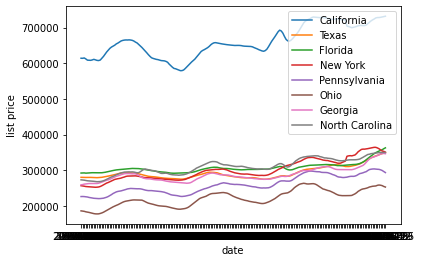

In [31]:
# preliminary plotting to get a feel.

import seaborn as sns

sns.lineplot(data=ca_list, x="date", y="list price", label = "California")
sns.lineplot(data=tx_list, x="date", y="list price", label = "Texas")
sns.lineplot(data=fl_list, x="date", y="list price", label = "Florida")
sns.lineplot(data=ny_list, x="date", y="list price", label = "New York")
sns.lineplot(data=pa_list, x="date", y="list price", label = "Pennsylvania")
sns.lineplot(data=oh_list, x="date", y="list price", label = "Ohio")
sns.lineplot(data=ga_list, x="date", y="list price", label = "Georgia")
sns.lineplot(data=nc_list, x="date", y="list price", label = "North Carolina")

# california is predictably absurdly priced

<AxesSubplot:xlabel='date', ylabel='sale price'>

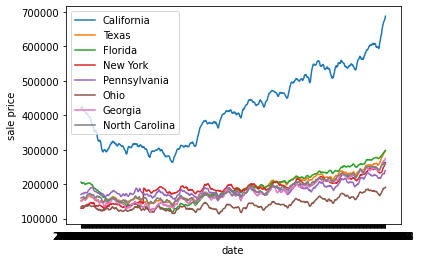

In [32]:
sns.lineplot(data=ca_sale, x="date", y="sale price", label = "California")
sns.lineplot(data=tx_sale, x="date", y="sale price", label = "Texas")
sns.lineplot(data=fl_sale, x="date", y="sale price", label = "Florida")
sns.lineplot(data=ny_sale, x="date", y="sale price", label = "New York")
sns.lineplot(data=pa_sale, x="date", y="sale price", label = "Pennsylvania")
sns.lineplot(data=oh_sale, x="date", y="sale price", label = "Ohio")
sns.lineplot(data=ga_sale, x="date", y="sale price", label = "Georgia")
sns.lineplot(data=nc_sale, x="date", y="sale price", label = "North Carolina")

# california is predictably still absurdly priced

<AxesSubplot:xlabel='date', ylabel='sale price'>

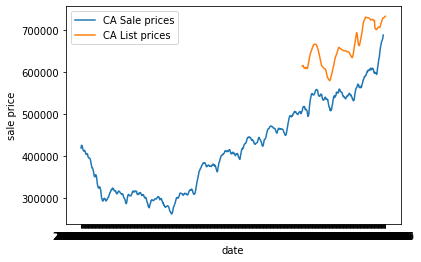

In [33]:
sns.lineplot(data=ca_sale, x="date", y="sale price", label = "CA Sale prices")
sns.lineplot(data=ca_list, x="date", y="list price", label = "CA List prices")


In [40]:
ca_list["region_name"] = "California"
ca_sale["region_name"] = "California"


In [47]:
ca_state_df = ca_list.merge(ca_sale, on = ["region_name","date"], how = "right")
ca_state_df = ca_state_df.dropna().drop(columns= "size_rank_y").rename(columns={"size_rank_x":"size_rank"})
ca_state_df = ca_state_df[["size_rank", "region_name", "list price", "sale price"]]
ca_state_df


,size_rank,region_name,list price,sale price
date,,,,
2017-11-04,36.4,California,614123.700000,508281.3
2017-11-11,36.4,California,613946.700000,514450.0
2017-11-18,36.4,California,614898.400000,516943.9
2017-11-25,36.4,California,612118.700000,517912.7
2017-12-02,36.4,California,608753.300000,517612.8
...,...,...,...,...
2021-04-24,36.4,California,718772.222222,670775.6
2021-05-01,36.4,California,721707.666667,672663.2
2021-05-08,36.4,California,724127.444444,676422.7


In [ ]:
ca_state_df["list/sale %"] = (ca_state_df["sale price"] / ca_state_df["list price"]) * 100
ca_state_df["list/sale actual"] = (ca_state_df["list price"] - ca_state_df["sale price"])
ca_state_df.head()

In [ ]:
ca_state_df.to_csv("resources/ca_state.csv")